## 2. Fasea: Algoritmoak diseinatzen

 Bigarrengo fase honetan, hiru algoritmo diseinatu beharko dira. Lehenengoa, algoritmo eraikitzaile bat izango da. Bigarrena, soluzio bakarrean oinarritutako heuristiko bat izan beharko du, eta azkenik, hirugarrena algoritmo poblazional bat izango da. Hiru algoritmoak estokastikoak izan beharko dute, eta horietatik, bik, oinarri probabilistikoa izan beharko dute. Adibidez, Simulated Annealing, Estimation of Distribution Algorithms (EDAk) edota Ant Colony Optimization (ACO) implementatu daitezke. Proiektu honen kasuan, algoritmoen helburua, komunitate kopuru jakin bat emanik, modularitatea maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

In [512]:
### Aurreko faseko kodigoa ###

# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

import numpy as np
import math
from operator import itemgetter


# pip install ipynb exekutatu liburutegi hau erabili ahal izateko.
from itertools import product
#from ipynb.fs.full.CDP_Sarrera_Ikasle import sortu_grafoa 
import community
import networkx as nx
import numpy as np
np.set_printoptions(threshold=20)

### Helburu-funtzioa
def modularitatea(G, partizioa, weight='weight'):
    
    ### Bete hemen 15-20 lerro
    e = dict([]) # eii
    a = dict([]) # aii
    m = G.size()
    modul = 0
    
    for v in G:
        com = partizioa[v] # u ze komunitatean dagoen
        a[com] = a.get(com,0) + G.degree(v, weight=weight) # u dagoen komunitatearen nodo bakoitzaren degree gehitzen joan
        
        for w, datas in G[v].items(): # u nodoaren auzokidea
            if partizioa[w] == com: # u eta w partizio berekoak
                if v == w:
                    e[com] = e.get(com, 0) + datas[weight] * 2
                else:
                    e[com] = e.get(com, 0) + datas[weight]     
    
    for com in set(partizioa.values()):
        modul += (e.get(com, 0) / (2*m)) - (a.get(com, 0) / (2*m)) ** 2

    return modul


Lehenik eta behin, problemaren tamaina murriztu behar da. Aurreko 2 faseetan problemaren grafoa eta soluzioaren errepresentazioa zehaztu da. Naiz eta egokiak izan, problemaren tamaina oso handia da optimizazioa on bat lortzeko zentzuzko denbora batean. Problemaren murrizketa kontu haundiz egin beharra da, problema osotara aldatu dezake eta. Baina, eskura dugun grafoa oso aproposa da problema txikiagoa bihurtzeko. 

Begiratu aurretik eraiki dugun grafoaren irudia. Kanpoaldean dauden nodoek ez dute ia loturarik beste nodoekin. Bestalde, barnealdean lotura asko daude. Gure helburua nodoen arteko loturek eraikitzen duten komunitateak lortzea da. Beraz, garbi dago komunitateak sortzeko barnealdeko nodoek garrantzi handiagoa edukiko dutela. 

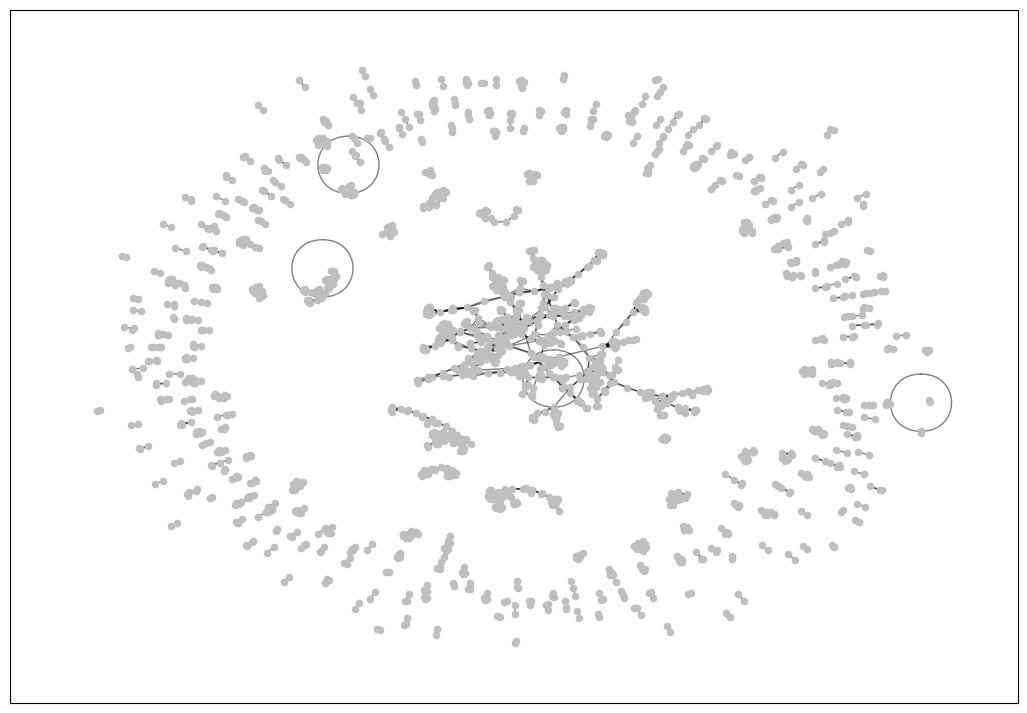 </td>
<center> Figure 1: NIPS problemaren grafoa.

Gainontzekoekin loturarik ez duten nodoak ezabatzean problemaren tamaina asko murriztuko da kalterik eragingo amaierako soluzioan. Beraz, erabaki ona da grafoa murriztea. Horretarako, gradua 5 baino gutxiago duten nodoak ezabatu dira (hau da, 5 ertz baino gutxiago dutenak). Honela, 1843 nodo izatetik 418 izatera pasa gara, problema 3 aldiz murriztuz. Gure grafoa hurrengo irudikoa bihurtu da:

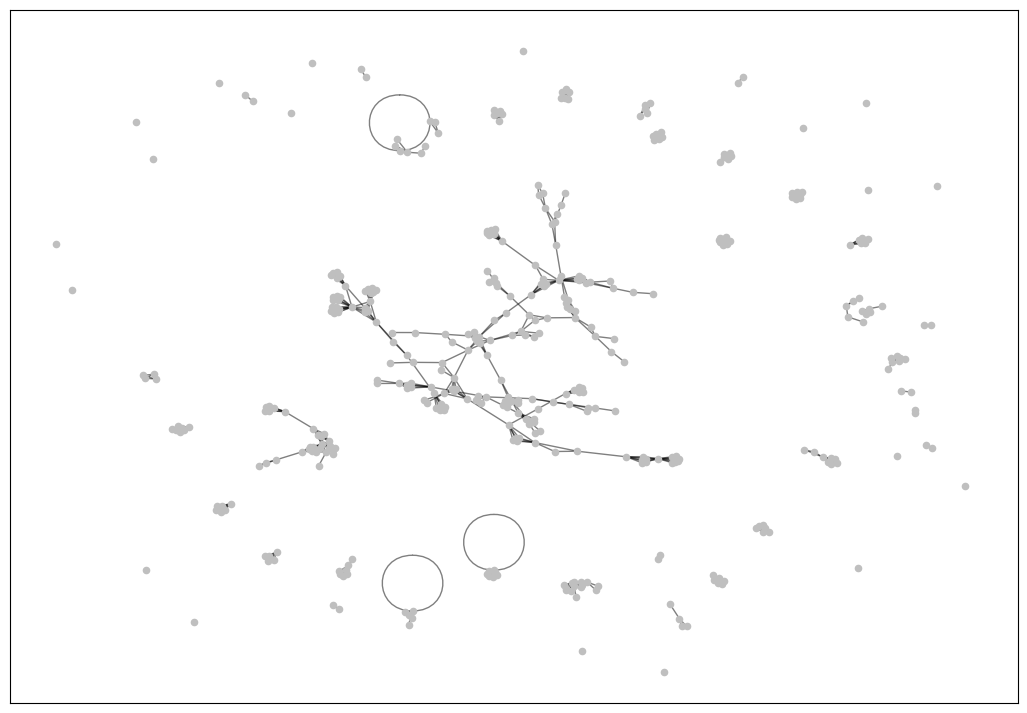 </td>
<center> Figure 2: Murriztutako grafoa.

Aurreko fasean grafoa sortzeko funtzioa aldatu hau lortzeko. Zehazki, komentarioen artean dagoena gehitu da.

In [513]:
def sortu_grafoa():
    
    # Datuak irakurri
    # BETE HEMEN 8 lerro
    connect = sqlite3.connect('./data/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)
    
    # Sortu grafoa
    # BETE HEMEN 7-10 lerro
    
    # Initialize graph
    G = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
                
    ######### Grafoa murrizteko ########
    original_len = G.number_of_nodes() 
    deleted_node = [] 
    deleted = [] # ezabatuen indizea gorde gero berriro gehitzeko     
    for i, elem in enumerate(G):
        if G.degree(elem) < 5:
            deleted.append(i)
            deleted_node.append(elem)
    G.remove_nodes_from(deleted_node) # ezabatu
    ####################################
            
    # Print graph size 
    print('\nAutore kopurua grafoan:', G.number_of_nodes())
    print('\nElkarlan kopurua grafoan:', G.number_of_edges())
    
    return G, deleted, original_len

### Dei orokorrak
G, deleted, original_len = sortu_grafoa()


Autore kopurua grafoan: 418

Elkarlan kopurua grafoan: 959


Soluzioen errepresentazioaren ideia berdina da, baina tamaina aldatu da. Probak egiterakoan emaitza hobeak lortu dira horrela, baina, amaieran gure hasierako problemara bueltatu beharra gara. Hau da, 418-ko soluzioetatik 1843 soluzio originalera pasa. Ezabatu ditugun nodoak berdin zaizkigu ze komunitatekoak diren, beraz ausaz edozein txertatu diezaiokegu. Kasu honetan, ausaz ipini beharrean ezabatutako nodoei komunitate kantitatea +1 jarri zaie. Honela adierazten dugu berdin zaigula ze komunitatekoak diren. Hau onartzeko soluzioen errepresentazioa aldatu beharko da. Hala ere, honen helburua ze nodo garrantzitsuak diren jakitea da, bestela ausaz komunitate bat jartzearekin nahikoa izango zen.

Hurrengo funtzioak, soluzio bat eta ze posioetan gehitzeko indizeak pasata, soluzioa tamaina originalera itzultzen du. 

In [514]:
def osatu_soluzioa(best_solution, deleted, original_len, numCom):
    sol = []
    cont = 0
    for i in range(original_len): 
        if i in deleted: # ez da borratu nodo
            sol.append(numCom+1) # bestela: sol.append(np.random.randint(numCom))
        else:
            sol.append(best_solution[cont])
            cont += 1
    return np.array(sol)

#Proba
a = [1, 2, 3, 4, 5, 6]
ezabatuak = [0, 2, 3, 8]
print(osatu_soluzioa(a, ezabatuak, 10, 10))

[11  1 11 11  2  3  4  5 11  6]


Aurreko guzti hau azalduta, problema ebazteko inplementatu diren 2 algoritmo ikusiko dira: algoritmo plobazional bat eta soluzio bakarrean oinarritutako heuristiko bat. Bi algoritmoak pausuz pausu azalduko dira hartu diren erabakiak azalduz:

## - Algoritmo Poblazionala

Algoritmo poblazional bezela algoritmo genetiko bat inplementatu da.


### Algoritmo Genetikoa
Algoritmo genetiko bat Darwinek proposatu zuen hautespen naturaleko eredua erreplikatzen saiatzen da. Eredu horrek, funtsean, populazio baten barruan bizirik irauten duten indibiduoak ingurunera gehien egokitzen direnak direla dio. Honela, guraso hoberenen geneak eskuratzen duten indibiduoek hobekien egokituta daudenak dira. Beraz, belaunaldi berriak geroz eta hobe egokitutzen dira, aurreko belaunaldietako gene onenen konbinazioa baitira.

Honetaz gain, eboluzioaren teoria horrek oso kontzeptu interesgarria gehitzen du: mutazioak. Mutazio bat aldaketa txiki bat da, ausaz gertatzen dena zenbait indibiduotan, eta, hartara, dibertsifikazioa haunditzen du populazioetan. Aldaketa hauek onuragarriak edo kaltegarriak izan daitezke.

Baina, zergatik erabili algoritmo genetikoa gure probleman? Algoritmo genetikoak bilaketa- eta optimizazio-problemak ebazteko erabiltzen dira, populazioak problemaren balio hoberenetarantz eboluzionatzean oinarritzen baitira. Beraz, gure problemarentzat egokia izan daiteke.

**Algoritmo genetiko baten egitura:**

Algoritmo genetikoen egitura ulertzeko, lehenik erabilgarriak izango diren termino batzuk barneratu beharra dira:
- `Indibiduo:` problemaren araberako soluzio posible bat.
- `Populazioa:` indibiduo multzoa.
- `Helburu-funtzioa:` indibiduoak ebaluatzen dituen funtzioa. Gure problema, aurretik azaldu den modularitatea.

Honela, algoritmo genetiko baten egitura edo fluxua hurrengoa da: 
1. Hasierako populazioa sortu.
2. Populazioa ebaluatu helburu-funtzioa erabiliz. 
3. Aukeraketa operadorea: uneko populaziotik indibiduo batzuk aukeratu.
4. Birkonbinaketa operadorea: populaziotik aukeratutakoekin indibiduo berriak sortu.
5. Mutazio operadorea: ausaz populazioko indibiduo batzuetan aldaketa txikiak dibertsifikazioa lortzeko.
6. Eguneraketa operadora: belaunaldi berrira eraiki.
7. Gelditze irizpidea ez bada bete itzuli 2. puntura.

Grafikoki errexago ulertzeko begiratu hurrengo irudia:
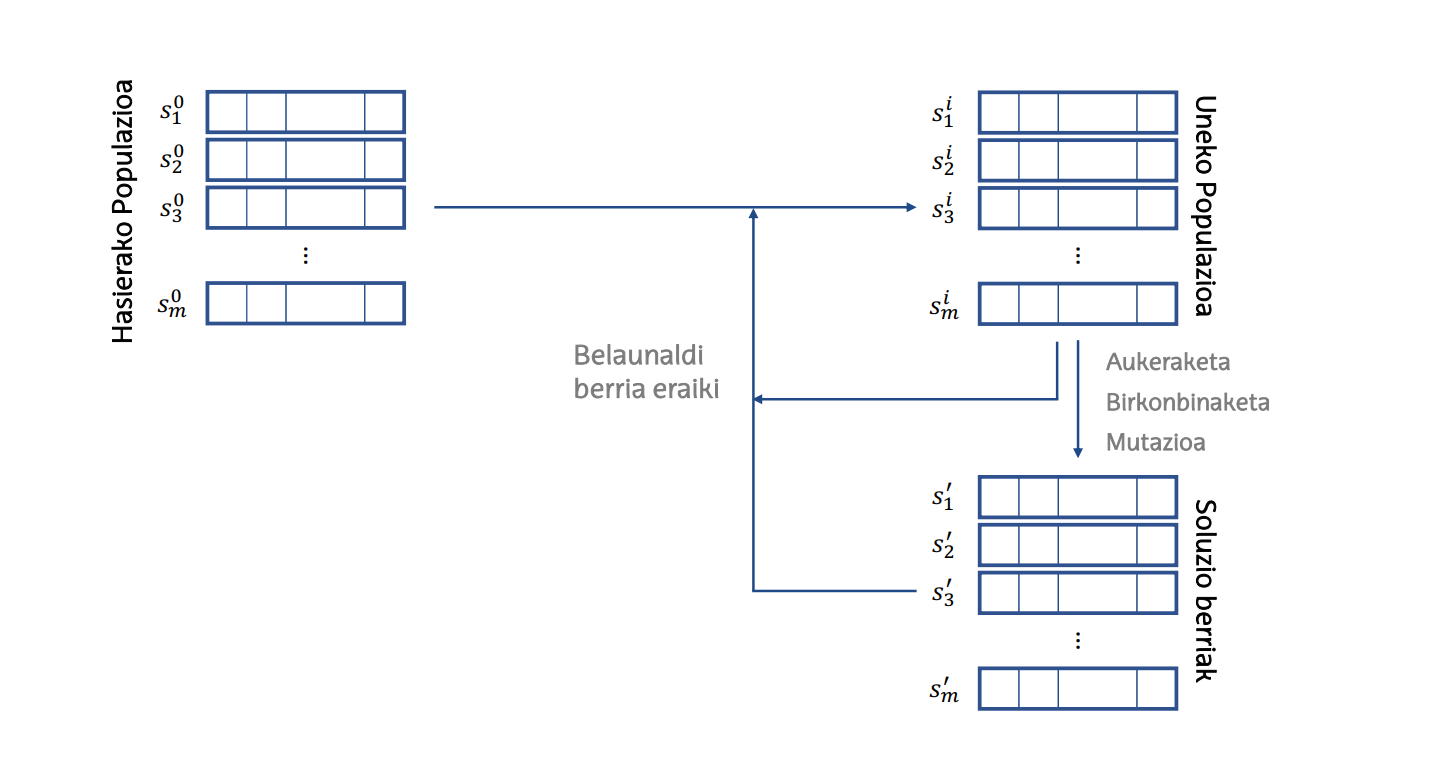 </td>
<center> Figure 3: Algoritmo genetikoaren fluxua.


Azkenik, operadoreek erabili ditzazketen irizpide desberinak eta inplementazioan erabili direnak azalduko dira:
 

### Hasieraketa
Hasierako populazioa sortzeko modu desberdinak daude, hala nola, ausaz, banaketa probabilistiko bat jarraituz, algoritmo heuristiko eraikitzaile baten bitartez etab. Kasu honetan, `ausaz` sortu da dibertsifikazioa mantentzeko egokia delako eta inplementatzeko erraza.

In [515]:
def hasieraketa_random(pop_size, sol_len, numCom):
    """ Funtzio honek populazio bat ausaz sortzen du. 
        Sarrerako parametroak:
            - pop_size: populazioaren tamaina (zenbat indibiduo)
            - sol_len: soluzoaren luzeera. Kasu honetan, grafoak dituen nodo kopurua
            - numCom: komunitate kopurua. 
        
        Irteera: soluzioak gordetzen dituen numpy array bat   
    """
    population = np.zeros((pop_size, sol_len), dtype=int) # populazioa gordetzeko 
    for i in range(pop_size):
        solution = np.random.randint(numCom, size=sol_len) # ausaz soluzio posible bat sortu
        population[i] = solution       
    return population

# Proba lagin txiki batekin funtzionamendua ikusteko:
pop_size = 15
sol_len = G.number_of_nodes()
numCom = 10
populazioa = hasieraketa_random(pop_size, sol_len, numCom)
print(populazioa)

[[6 5 5 ... 8 8 4]
 [2 8 4 ... 9 0 2]
 [0 7 2 ... 3 6 2]
 ...
 [3 8 8 ... 4 3 6]
 [7 1 7 ... 3 9 0]
 [3 1 6 ... 4 3 5]]


### Soluzioak ebaluatu
Populazio bakoitzeko soluzio bakoitza ebaluatu nahi da ea zein onak diren jakiteko. Horretarako, aurretik azaldu den modularitate helburu-funtzioa erabiltzen da. Problema hau haundia denez, egokiena soluzio bakoitzaren fitness-a gordetzea da (aurrerago berriro kalkulatu beharrean). Beraz, sarrerako populazioko indibiduo bakoitzari bere fitness-a gehitzen zaio tupla batean gordetuz. Horretaz gain, ebaluazio kantitatea eguneratzen da helburu-funtzioa kalkulatzen den bakoitzean. Hau izango da gure gelditze irizpidea, ebaluazio maximo batera iristean amaitu.

In [516]:
def soluzioak_ebaluatu(G, population, evals):
    """ Funtzio honek populazio bateko soluzio guztiak ebaluatzen ditu helburu-funtzioa erabiliz. 
        Sarrerako parametroak:
            - G: problemaren grafoa
            - population: ebaluatu nahi den populazioa
            - evals: ebaluaketa kopurua eguneratzeko 
        
        Irteera: 
            - ebaluatuak: sarrerako populazioa, baina orain soluzio bakoitza bere fitness-arekin gordetzen da tupla batean 
            - evals: ebaluaketa kopurua eguneratua
    """
    ebaluatuak = []
    for sol in population:
        partition = dict(zip(G.nodes, sol)) 
        fitness = modularitatea(G, partition)
        ebaluatuak.append((fitness, sol))
        evals += 1 
    return ebaluatuak, evals

# Proba lagin txiki batekin funtzionamendua ikusteko:
ebaluatuak, _ = soluzioak_ebaluatu(G, populazioa, 0)
for i in range(len(ebaluatuak)):
    print(ebaluatuak[i])

(-0.02504237882483166, array([6, 5, 5, ..., 8, 8, 4]))
(-0.03822901636545715, array([2, 8, 4, ..., 9, 0, 2]))
(-0.03063290423527289, array([0, 7, 2, ..., 3, 6, 2]))
(-0.01571142602706808, array([3, 2, 9, ..., 8, 2, 7]))
(-0.01828351352262361, array([4, 0, 5, ..., 9, 0, 2]))
(-0.01357318461510023, array([0, 8, 7, ..., 2, 0, 9]))
(-0.023840875260008634, array([5, 8, 8, ..., 6, 3, 8]))
(-0.0069214216668605725, array([7, 6, 9, ..., 8, 5, 5]))
(-0.007704301817695478, array([4, 5, 8, ..., 1, 0, 0]))
(-0.02525386519891136, array([9, 8, 5, ..., 2, 9, 4]))
(-0.029506426684904878, array([9, 7, 2, ..., 4, 5, 9]))
(0.0023812604587895095, array([5, 8, 7, ..., 7, 5, 5]))
(-0.0038252394036627996, array([3, 8, 8, ..., 4, 3, 6]))
(-0.014783386848265872, array([7, 1, 7, ..., 3, 9, 0]))
(-0.01850967889953147, array([3, 1, 6, ..., 4, 3, 5]))


### Aukeraketa operadorea
Uneko populaziotik indibiduo batzuk aukeratu nahi dira ondoren birkonbinaketa aplikatzeko. Aukeraketa hau egiteko irizpide desberdinak daude: 
- `Truncation Selection:` ingurune bateko k hoberenak hartu. Ohikoa eta merkea, baina dibertsitatea azkar murrizten du.
- `Roulette Wheel Selection:` soluzio bakoitzari probabilitate bat ezarri eta ondoren ausaz aukeratu (fitness handienak dutenak aukera gehiago). Konputazionalki ez da oso garestia eta dibertsitate ona lortzen du, baina super-soluzioekin gaizki funtzionatzen du.
- `Metodo gehio badaude:` Rank Selection, Steady State Selection, Tournament Selection etab.

Kasu honetan, `Truncation Selection` erabili da problema handi honetan inplementazio merkea nahiago delako.

In [517]:
def aukeraketa_operadorea(ebaluatuak, num_sel):
    """ Funtzio honek populazio bateko num_sel soluzio aukeratzen ditu Truncation Selection jarraituz. 
        Sarrerako parametroak:
            - ebaluatuak: soluzio bakoitza bere fitness-arekin tupla moduan gordetzen duen lista
            - num_sel: zenbat soluzio aukeratu
            
        Irteera: soluzio bakoitza bere fitness-arekin tupla moduan gordetzen duen lista
    """
    ordenatua = sorted(ebaluatuak, key=itemgetter(0), reverse=True) 
    hoberenak = ordenatua[:num_sel]
    return hoberenak

# Proba lagin txiki batekin funtzionamendua ikusteko:
num_sel = 8
aukeratuak = aukeraketa_operadorea(ebaluatuak, num_sel)
for i in range(len(aukeratuak)):
    print(aukeratuak[i])

(0.0023812604587895095, array([5, 8, 7, ..., 7, 5, 5]))
(-0.0038252394036627996, array([3, 8, 8, ..., 4, 3, 6]))
(-0.0069214216668605725, array([7, 6, 9, ..., 8, 5, 5]))
(-0.007704301817695478, array([4, 5, 8, ..., 1, 0, 0]))
(-0.01357318461510023, array([0, 8, 7, ..., 2, 0, 9]))
(-0.014783386848265872, array([7, 1, 7, ..., 3, 9, 0]))
(-0.01571142602706808, array([3, 2, 9, ..., 8, 2, 7]))
(-0.01828351352262361, array([4, 0, 5, ..., 9, 0, 2]))


### Birkonbinaketa operadorea
Aukeratu diren soluzioekin indibiduo berriak sortu nahi dira gurasoen propietateak (gene honak) eta bideragarritasuna mantenduz. Modu desberdinetan egin daiteke, baina hemen inplementatu dena `One-Point Crossover` izan da. Honetarako, soluzioko puntu bat ausaz aukeratzen da eta puntu horretatik guraso baten ezkerreko zatia bestearen eskuineko zatiarekin gehitzen da (berdina beste alderdiarekin). Honela, bi gurasoekin 2 indibiduo berri sortzen dira. Parametro berri bat gehitzen da: off_size. Honek sortuko diren soluzio berrien kopurua adierazten du (off_size-en erdia erabiliko da).

Konputazionalki merkea denez eta problema honetan soluzio bideragarriak sortzen dituenez (zehaztutako soluzioen erepresentazioa errespetatzea), erabiltzeko egokia.   

In [518]:
def birkonbinaketa_operadorea(aukeratuak, off_size, sol_len):   
    """ Funtzio honek populazio batetik 2 soluzio ausaz aukeratu eta One-Point Crossover erabiliz 2 soluzio berri sortzen ditu.
        Sarrerako parametroak:
            - aukeratuak: birkonbinaketa egin nahi den populazioa. Tupla bakoitzeko soluzioak eta fitnessa gordetzen duen lista.
            - off_size: sortuko diren soluzio berri kopurua
            - sol_len: soluzoaren luzeera. Kasu honetan, grafoan dauden nodo kopurua
        
        Irteera: soluzio berriak gordetzen dituen lista (fitness gabe) 
    """
    population = [sol[1] for sol in aukeratuak] # tuplak direnez, soluzioekin bakarrik geratu (eta ez fitness)
    new_pop = []
    
    for i in range(off_size // 2):
        index_sel1 = np.random.randint(len(aukeratuak)) # ausaz aukeratu 2 indibuduo (indizeak)
        index_sel2 = np.random.randint(len(aukeratuak))
        sel1 = population[index_sel1] # aukeratu birkonbinaketarako biak
        sel2 = population[index_sel2]
        
        pos = np.random.randint(sol_len) # pos bat ausaz
        new1 = np.append(sel1[:pos], sel2[pos:]) # berriak sortu
        new2 = np.append(sel1[pos:], sel2[:pos])
        
        new_pop.append(new1)
        new_pop.append(new2)
    
    return new_pop

# Proba lagin txiki batekin funtzionamendua ikusteko:
off_size = 15
sol_len = G.number_of_nodes()
popBerria = birkonbinaketa_operadorea(aukeratuak, pop_size, sol_len)
for i in range(len(popBerria)):
    print(popBerria[i])

[7 1 7 ... 8 5 5]
[4 7 3 ... 9 2 0]
[4 5 8 ... 1 0 2]
[0 4 0 ... 9 9 0]
[7 6 9 ... 2 0 9]
[7 0 5 ... 9 9 7]
[7 6 9 ... 8 5 5]
[5 5 2 ... 8 7 0]
[3 2 9 ... 9 0 2]
[4 6 3 ... 6 3 5]
[4 0 5 ... 8 2 7]
[2 1 7 ... 6 8 7]
[3 8 8 ... 4 3 6]
[5 2 6 ... 2 7 0]


### Mutazio operadorea
Birkonbinaketan sortu diren soluzioei ausazko aldaketa txiki batzuk gehitzea da. Soluzio bakoitzeko gene bakoitzean zehaztutako probabilitate bat (mutProb) baino txikiagoa lortzen bada, mutazioa aplikatzen da. Hainbat metodo desberdin daude honetarako, baina kasu honetan  `Bit-Mutation` metodoa erabili da: gene hori ausazko beste zenbaki batekin aldatu, bideragarritasuna mantenduz.   

Honela, debertsifikazioa handitzen da, noizean behin soluzio hobeago bat emanez (kasu hau ematen bada, bilaketa espazioa esplorazio moduan sakonago aztertu daiteke soluzio hobeen esperoan).

In [519]:
def mutazio_operadorea(popBerria, mutProb, numCom):
    """ Funtzio honek populazio batetik 2 soluzio ausaz aukeratu eta One-Point Crossover erabiliz 2 soluzio berri sortzen ditu.
        Sarrerako parametroak:
            - popBerria: birkonbinaketan lortu diren soluzioak gordetzen duen lista.
            - mutProb: mutazio probabilitatea.
            - numCom: komunitate kopurua.
        
        Irteera: soluzio berriak gordetzen dituen lista (fitness gabe) 
    """
    for sol in popBerria: # indibiduo bat hartu
        for gen in sol: # gene bakoitzan mutazio probabilitatea aztertu
            randProb = np.random.uniform(0, 1)
            if randProb < mutProb:
                sol[gen] = np.random.randint(numCom)
    return popBerria

# Proba lagin txiki batekin funtzionamendua ikusteko:
mutProb = 0.02
numCom = 10
mutatuak = mutazio_operadorea(popBerria, mutProb, numCom)
for i in range(len(mutatuak)):
    print(mutatuak[i])

[9 1 3 ... 8 5 5]
[4 0 3 ... 9 2 0]
[4 5 8 ... 1 0 2]
[0 3 4 ... 9 9 0]
[9 6 9 ... 2 0 9]
[8 0 5 ... 9 9 7]
[7 4 1 ... 8 5 5]
[3 1 1 ... 8 7 0]
[9 7 9 ... 9 0 2]
[4 6 4 ... 6 3 5]
[4 0 3 ... 8 2 7]
[8 0 7 ... 6 8 7]
[3 2 2 ... 4 3 6]
[5 1 4 ... 2 7 0]


### Eguneraketa operadorea
Populazio berria eta zaharretik belaunaldi berrira ze soluzio pasa behar diren aukeratu nahi da. Aukera desberdinak daude, baina ohikoena inplementatu da:  bi populazioak batera jarri, ordenatu eta m soluzio onenak aukeratu.

In [520]:
def eguneraketa_operadorea(oldEvaluated, newPopulation, pop_size, evals):
    """ Funtzio honek 2 populazio jaso eta hauen arteko pop_size hoberank itzultzen ditu
        Sarrerako parametroak:
            - oldEvaluated: guraso populazio soluzio bakoitza bere fitness-arekin (ebaluatua)
            - newPopulation: mutaziotik atera berri den populazioa ebaluatu gabe
            - pop_size: populazio berriaren tamaina
            - evals: ebaluaketa kopurua eguneratzeko (berriak ebaluatu egingo dira eta)
        
        Irteera: 
            - hoberenak: soluzio hoberenak bere fitness-arekin tupla moduan gorsetzen dituen lista
    """
    newEvaluated, evals = soluzioak_ebaluatu(G, newPopulation, evals)
    tot = oldEvaluated + newEvaluated

    ordenatua = sorted(tot, key=itemgetter(0), reverse=True)
    hoberenak = ordenatua[:pop_size]
    return hoberenak, evals

# Proba lagin txiki batekin funtzionamendua ikusteko:
pop_size = 15
hoberenak, evals = eguneraketa_operadorea(aukeratuak, mutatuak, pop_size, 0)
for i in range(len(hoberenak)):
    print(hoberenak[i])

(0.00777226016412212, array([5, 1, 4, ..., 2, 7, 0]))
(0.0023812604587895095, array([5, 8, 7, ..., 7, 5, 5]))
(0.00233287411613374, array([4, 0, 3, ..., 9, 2, 0]))
(-0.0009285828455736283, array([3, 1, 1, ..., 8, 7, 0]))
(-0.0038252394036627996, array([3, 8, 8, ..., 4, 3, 6]))
(-0.0042634348214217795, array([4, 0, 3, ..., 8, 2, 7]))
(-0.006678402620038906, array([3, 2, 2, ..., 4, 3, 6]))
(-0.0069214216668605725, array([7, 6, 9, ..., 8, 5, 5]))
(-0.007704301817695478, array([4, 5, 8, ..., 1, 0, 0]))
(-0.00812836189939772, array([0, 3, 4, ..., 9, 9, 0]))
(-0.009354874135705744, array([9, 6, 9, ..., 2, 0, 9]))
(-0.00951579950004403, array([7, 4, 1, ..., 8, 5, 5]))
(-0.011682311584125363, array([4, 5, 8, ..., 1, 0, 2]))
(-0.01357318461510023, array([0, 8, 7, ..., 2, 0, 9]))
(-0.014783386848265872, array([7, 1, 7, ..., 3, 9, 0]))


### Inplementazioa
Algoritmo genetiko baten atal guztien funtzionamendua eta inplementazioa ulertu dela, algoritmo general bat sortu da goiko egitura jarraituz eta inplementatu berri diren funtzioak erabiliz:

In [521]:
def genetic_algorithm(G, numCom, sol_len, pop_size, num_sel, off_size, mutProb, max_evals):
    evals = 0
    populazioa = hasieraketa_random(pop_size, sol_len, numCom)
    while evals < max_evals:  # stop_criterion = ebaluazio kopurua 
        ebaluatuak, evals = soluzioak_ebaluatu(G, populazioa, evals)
        aukeratuak = aukeraketa_operadorea(ebaluatuak, num_sel)
        popBerria = birkonbinaketa_operadorea(aukeratuak, off_size, sol_len)
        popMutatuak = mutazio_operadorea(popBerria, mutProb, numCom)
        populazioBerria, evals = eguneraketa_operadorea(ebaluatuak, popMutatuak, pop_size, evals)
        populazioa = [x[1] for x in populazioBerria] # hurrengo iteraziorako soluzioak bakarrik behar dira ebaluatzeko
        
    
    # Azken populaziotik soluzio hobrerena
    popAzkena = sorted(populazioBerria, key=itemgetter(0), reverse=True)
    best_fitness = popAzkena[0][0]
    best_solution = popAzkena[0][1]
    return best_fitness, best_solution, evals

### Parametroak

Algoritmoaren funtzionamendu egoki bat nahi bada erabiltzen diren parametroak kontuan eduki behar dira. Parametro desberdinak erabiliz algoritmoak portaera desberdina edukiko du, amaierako soluzioa aldatuz. Laburbilduz, hurrengo hauek dira erabili diren parametroak:
- `G:` problemaren grafoa.
- `numCom:` komunitate kopurua. Balio desberdinak hartu ditzazke.
- `sol_len:` indibiduo/soluzio bakoitzaren tamaina. G grafoan dauden nodo kopurua.
- `pop_size:` populazio baten tamaina. Sortu berri diren populazio guztiek tamaina berdina izango dute.
- `num_sel:` aukeraketa operadorean aukeratuko diren soluzio kopurua.
- `off_size:` birkonbinaketa operadorean sortuko diren soluzio berri kopurua.
- `mutProb:` mutaketa probabilitatea.
- `max_evals:` gelditze irizpide bezela helburu-funtzioaren ebaluazio lomite bat izango da.

Oraingoz ez gara gai balio egoki batzuk aukeratzeko. Beraz, parametro hauen balioak ausaz hartu dira oraingoz. Baina, 3. fasean 'parameter tunning' erabiliz balio egokiago batzuk hartzeko gai izango gara.

In [522]:
# Parametroak
numCom = 10
sol_len = G.number_of_nodes()
pop_size = 50
num_sel = 25
off_size = 50
mutProb = 0.02
max_evals = 5000

### Exekuzioa

Aukeratutako parametroekin exekuzio bat probatu da lortu den soluzio hoberena itzuliz:

In [523]:
# Deia
best_fitness, best_solution, evals = genetic_algorithm(G, numCom, sol_len, pop_size, num_sel, off_size, mutProb, max_evals)  

# Kodeaketa originalera itzuli
best_solution = osatu_soluzioa(best_solution, deleted, original_len, numCom)
    
print("Best Fitness: ", best_fitness)
print("Best Solution: ", list(best_solution))
print("Evaluations: ", evals)

Best Fitness:  0.08235953553460387
Best Solution:  [11, 11, 11, 11, 11, 11, 11, 11, 11, 2, 11, 11, 2, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1, 1, 11, 6, 11, 8, 11, 6, 6, 6, 0, 11, 2, 11, 6, 11, 11, 11, 11, 11, 8, 5, 4, 0, 8, 4, 1, 11, 11, 11, 11, 11, 8, 8, 11, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 4, 11, 6, 11, 11, 7, 11, 2, 11, 6, 11, 2, 11, 11, 11, 1, 2, 11, 7, 9, 6, 7, 6, 11, 7, 0, 11, 11, 8, 5, 11, 11, 4, 11, 1, 0, 8, 11, 6, 11, 11, 11, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 8, 9, 0, 5, 5, 7, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 2, 11, 11, 9, 11, 11, 2, 1, 11, 4, 8, 11, 11, 11, 11, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 11, 0, 7, 4, 11, 11, 11, 11, 8, 6, 8, 11, 11, 6, 11, 11, 11, 11, 7, 11, 2, 2, 6, 11, 11, 11, 11, 1, 11, 11, 3, 4, 2, 2, 6, 8, 2, 11, 11, 11, 11, 6, 11, 11, 11, 11, 11, 4, 11, 7, 11, 11, 11, 11, 11, 11, 0, 0, 11, 11, 7, 11, 11, 11, 11, 7, 11, 0, 7, 11, 0, 7, 11, 5, 11, 11, 11, 1

### Erreferentziak

-- Mursel Tasgin and Haluk Bingol. https://arxiv.org/ftp/cond-mat/papers/0604/0604419.pdf

-- Ranjan Kumar Behera, Debadatta Naik, Santanu Kumar Rath & Ramesh Dharavath. https://link.springer.com/article/10.1007/s00521-019-04487-0

$\newline$
## - Soluzio bakarrean oinarritutako heuristikoa

Simulated Annealing inplementatu da soluzio bakarrean oinarritutako heuristikoa bezela oinarri probabilistiko bat jarraitzen duelako.

### Simulated Annealing

Simulated Annealing algoritmoa optimizazio-problemak ebazteko metodo heuristiko gogokoenetako bat da. Algoritmo hau metafora batean oinarritua dago: metala suberatzeko prozeduran inspiratua. Suberaketa-prozedurak metal-partikulen moldaketa molekular optimoak definitzen ditu, non masaren energia potentziala minimizatu egiten da metalak pixkanaka hozten direnean. Prozesu hori egitean metalak propietate desiragarri batzuk lortzen ditu. Prozesu honetan tenperatura kontrolatzea oso garrantzitsua da. Behar bezala egiten bada, metalaren azken egoera energia minimoaren egoera da. Analogia hau simulatu nahi dugu guk Simulated Annealing algoritmoarekin gure problema optimizatzeko.

Simulated Annealing bilaketa globala optimizatzeko algoritmo estokastikoa da. Horrek esan nahi du ausazko bilaketa prozesuaren zati gisa erabiltzen duela. Hori dela eta, algoritmoa egokia da helburu funtzio ez-linealetarako, non beste bilaketa lokaleko algoritmo batzuek ez dute ongi funtzionatzen. Hill Climb bilaketa lokaleko algoritmoa bezela, soluzio bateko ingurunea aztertzen du optimo lokalera iritsi arte. Baina, Hill Climbining ez bezela, Simulated Annealing-ek momentuko soluzioa baino txarragoak onartu ditzazke optimo lokaletatik ihes egiteko helburuarekin.

Soluzio okerragoak onartzeko probabilitatea handia da bilaketaren hasieran, eta txikiagotu egiten da bilaketak aurrera egin ahala (metalaren metaforan tenperatura bezela). Honela, algoritmoari aukera ematen zaio bilaketa espazioa explorazio moduan aztertzea optimo globalaren eremua lokalizatzeko, optimo lokaletatik ihes egiteko helburuarekin. Behin tenperatura hozten doala, soluzio okerragoak onartzeko probabilitatea gutxitzen da eta, honela, lortu den eremu hoberenan bilaketa lokal bat egingo da. Probabilitate hau tenperatura eta energia diferentziaren (helburu funtzoa) menpe dago. Zehazki, honela kalkulatzen da: $ e^{-\frac{\Delta E }{T}} $.

Grafikoki ikusteko begiratu hurrengo irudia:

$\newline$
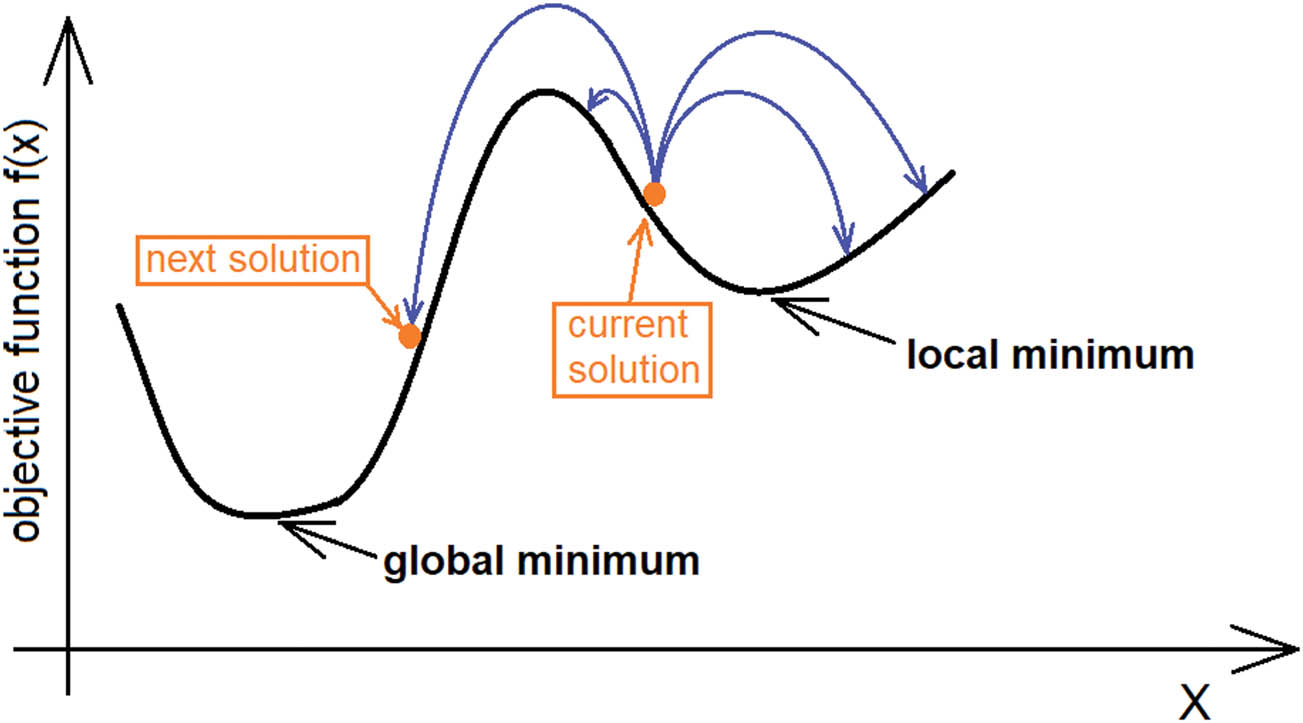 </td>
<center> Figure 4: Simulated Annealing algoritmoaren eredua.


Algoritmoaren pseudo-kodea ondorengoa da:

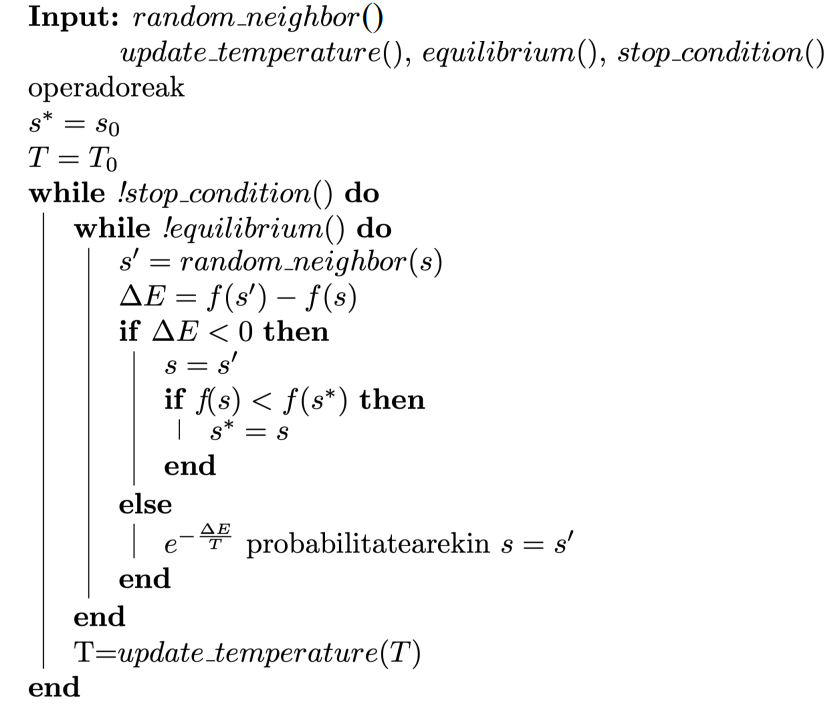 </td>


Hainbat irizpide hartu beharra dira kontuan: hasierako tenperatura, tenperaturaren eguneraketa, oreka, gelditze baldintza eta ingurune funtzioa. Ondoren, irizpide hauen azalpenak eta hartutako erabakiak aipatuko dira:

### Hasierako tenperatura
Algoritmoa hasi aurretik hasierako tenperatura erabaki beharra da. Aukera desberdinak daude, baina alderdi garrantzitsu bat hartu beharra da kontuan: hasierako tenperatura eta helburu funtzioen arteko diferentziak eskala antzekoan egotea. Tenperatura eta energia diferentziaren arteko aldea handia bada, soluzio txarrak onartzeko probabilitatea 0 edo 1 izango da. Kasu hau ematen bada, ez zen simulated annealing-etaz baliatuko (bilaketa lokala edo random search antzekoa bihurtuko zen). Arazo hau sahiesteko 2 modu daude: tenperaturaren eguneraketa oso ongi kontrolatu edo hasierako tenperatura zentzuzkoa hartu.

Hasierako tenperatura helburu funtzioen diferentziaren eskalan jartzen saiatuko gara. Horretarako, hurrengo formula erabili da: $ T_{0} = \frac{-\Delta  E}{ln(p)} = \frac{-\left (f_{u} - f_{l}  \right )}{ln(p)} $, non $f_{u}$ helburu-funtzioak hartu dezaken balio maximoa da eta $f_{l}$ balio minimoa. Erabilitako modularitate helburu funtzioan $f_{u} = 1$ eta $f_{l} = -0.5$ dira. Baina, problema honetan soluzioen harteko modularitatearen diferentzia oso txikia denez, balio maximo eta minimo hauek erabiltzeak hasierako balio handiegia emango digu. 

Muturreko balio hauek hartu beharrean, beste modu batean $f_{u}$ eta $f_{l}$ lortzea pentsatu da: helburu funtzioa askotan ebaluatu da (100.000 alditan) ausazko soluzioekin, balio maximoa eta minimoa aukeratuz (honen inplementazio ez da gomendatzen exekutatzea denbora asko iraungo du eta). Hauek izango dira erabiliko diren $f_{u}$ eta $f_{l}$ berriak eta goiko formularekin hasierako tenperatura egokiagoa lortuko da. Experimentuk egiterakoan honela emaitza hobeak lortu dira.

Bestalde, p-k hasieran edozein soluzio aukeratzeko probabilitatea adierazten du. Balio egoki bat p = 0.75 izan daiteke. Azaldutakoaren inplementazioa hurrengoa da:

In [524]:
# Ez da gomendatzen exekutatzea, denbora asko iraungo du
aux = []
for i in range(100000):
    sol = np.random.randint(numCom, size=G.number_of_nodes())
    part = dict(zip(G.nodes, sol))
    aux.append(modularitatea(G, part))
fu = max(aux)
fl = min(aux)
print("fu : ", fu)
print("fl : ", fl)

fu :  0.05317115391097566
fl :  -0.06991391580341444


In [534]:
def hasierako_temperatura(fu, fl):
    ediff = -(fu - fl)
    return ediff / np.log(0.75)

fu = 0.05317
fl = -0.06991
print("Hasierako tenperatura =", hasierako_temperatura(fu, fl))

Hasierako tenperatura = 0.42783340286395405


### Oreka
Tenperatura eguneratzen den bakoitzean hainbat iterazio egin nahi dira tenperatura berdinarekin. Normalean balio estatiko bat erabiltzen da iterazio guztietarako. Balioa kalkulatzeko hurrengo formula erabiltzen da: $ \rho \left | N(s) \right |, non \ \rho \in \left [ 0, 1 \right ] $. Hau da, ingurune funtzioaren kardinaltasunari ausazko probabilitate bat biderkatzen zaio. Erabili den ingurune funtzioa ondoren azalduko da, baina, laburbilduz, guk hamming erabili dugu kardinaltasuna ez delakoz oso handia (n, soluzioaren tamaina). Problema handia denez, swap edo insert ingurune funtzioa erabiliko bazen hauek ematen duten kardinaltasuna oso handia da, beraz oreka balioa handiegia izango zen hoiekin. Hala ere, problema oraindik nahiko handia da eta iterazio asko egiteko gaitasuna ez dugunez p = 0.2 definitu da, oreka 83 iteraziok emanez. 

In [535]:
def oreka(sol_len):
    #p = np.random.uniform(0, 1)
    p = 0.2
    return (p * sol_len)

print("Oreka iterazio kopurua =", int(oreka(G.number_of_nodes())))

Oreka iterazio kopurua = 83


### Temperatura eguneraketa
Iterazioak pasa ahala soluzio txarrak gutxiagotan aukeratu nahi dira eta horretarako tenperatura gutxitu beharra da. Oso garrantzitsua hau ongi kontrolatzea, soluzio txarrak onartzeko probabilitatea honen menpe dago eta. Hainbat aukera daude: 

- `lineala:` Izenak dion bezela, tenperatura linealki gutxituko da. Horretarako erabili den azken tenperaturari $\beta$ balioa kenduko zaio eguneraketa bakoitzean 0-ra iritsi arte. Denboran zehar tenperaturaren bilakaera horrelakoa da, non garbi ikusten da oreka ebaluazioa bukatzen den bakoitzero linealki jeisten del atenperatura:
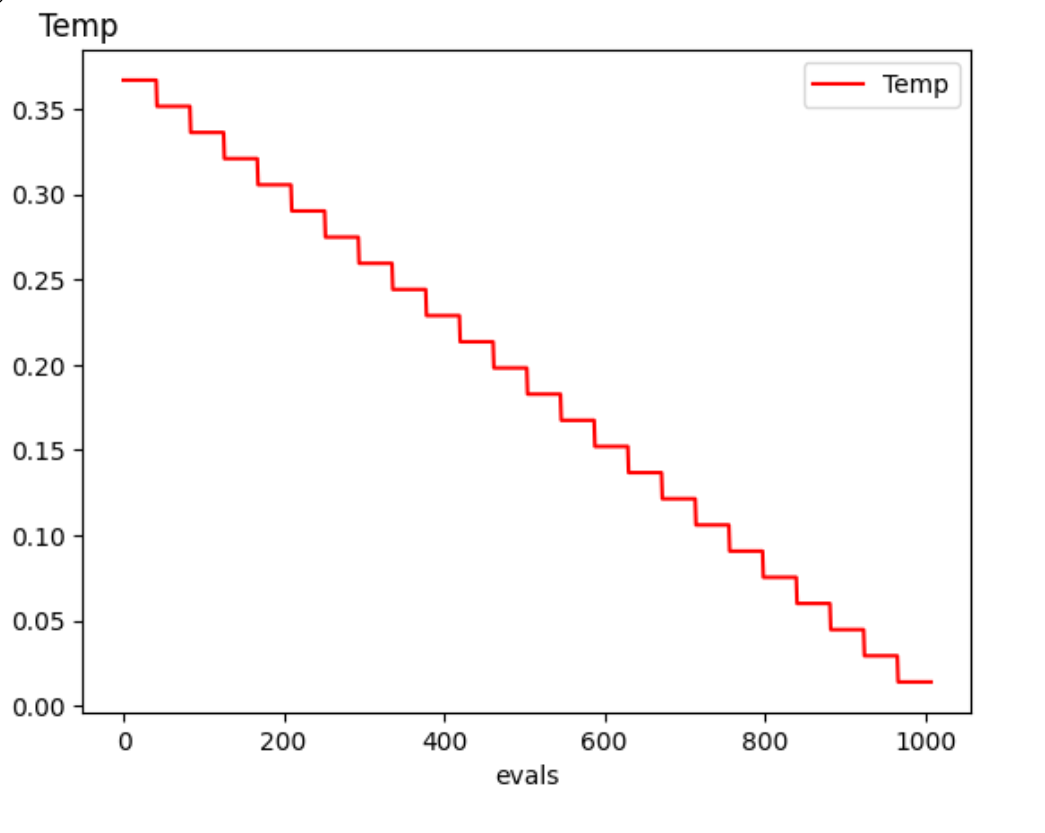 </td>
<center> Figure 5: Eguneraketa lineala.

   <br>Inplementazteko erraza da, baina $\beta$ balio egoki bat aukeratu beharra da. Balio hau hasierako tenperatura ($T_{0}$), ebaluazio kopuruaren eta oreka iterazio tamainaren menpe dago. Gure helburua $T_{0}$-n hastea eta 0 tenperaturan bukatzea da. Ebaluazio eta oreka kopurua zehaztuta erraza da $\beta$ kalkulatzea. Ondorengo ekuazioa erabili da: 
   $$ \begin{equation} 
     T_{0} - \frac{evals}{oreka}\beta = 0  \Rightarrow  \beta = t_{0}\frac{oreka}{evals}.
  \end{equation}  $$
  
  Kontuan izan erabili diren 3 parametroetako bat aldatzen bada $\beta$ berritik kalkulatu beharko dela. Behin $\beta$ lortu dela, tenperatura linealki honela eguneratzen da:
   $$ \begin{equation} 
     T_{i} = T_{i-1} - \beta.
  \end{equation}  $$
  

- `geometrikoa:` tenperatura esponenzialki gutxitzen da. Horretarako erabili den azken tenperaturari $\beta$ balioa biderkatuko zaio eguneraketa bakoitzean 0-ra iritsi arte. $\beta \in \left [ 0, 1 \right ]$ eta normalean 0.9 eta 1 arteko balioak erabiltzen dira. Hala ere, kalkulatzeko modua badago. Tenperaturaren eguneraketa honela egiten da:
    $$ \begin{equation} 
     T_{i} = T_{i-1} * \beta.
  \end{equation}  $$

  Eta denboran zehar tenperaturaren bilakaera horrelakoa da:
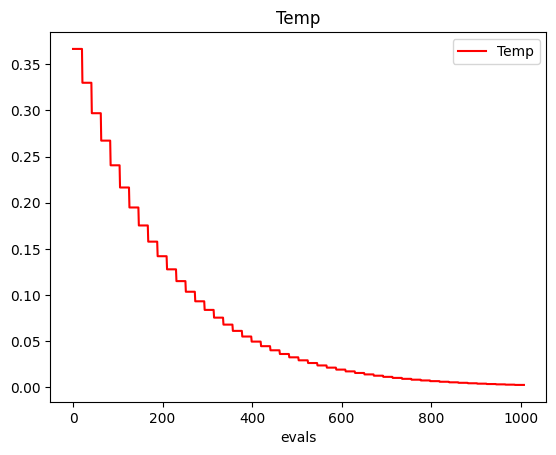 </td>
<center> Figure 6: Eguneraketa geometrikoa.

- `logaritmikoa:` tenperatura funtzio logaritmikoan gutxituko da, exponentziala baino motelago eta lineala baino azkarrago. Kasu honetan, aurreko tenperatura erabili beharrean, hasierako tenpertaura ($T_{0}$) eta zenbatgarren eguneraketaren indizea erabiltzen da. Formula hurrengoa da: 
    $$ \begin{equation} 
     T_{i} = \frac{T_{0}}{ln(i)}.
  \end{equation}  $$
   
    Eta denboran zehar tenperaturaren bilakaera horrelakoa da:
    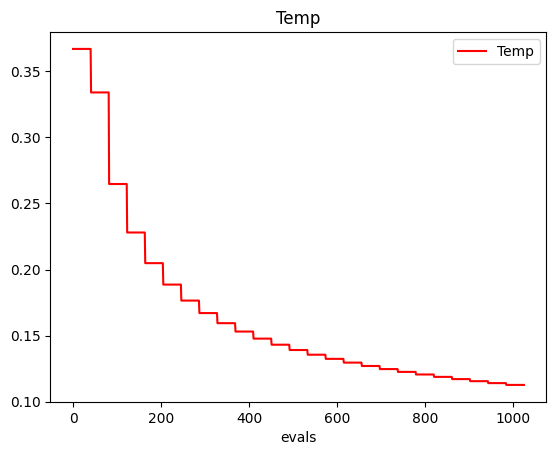 </td>
    <center> Figure 5: Eguneraketa logaritmikoa.

Guk lineala erabili dugu inplementatzeko erraza denez eta emaitza honak eman dituelako. $\beta$ lortzeko eta tenperatura eguneratzen duten funtzioak ondorengo hauek dira:

In [536]:
def lortu_beta(initialTemp, oreka, max_evals):
    beta = initialTemp / (max_evals / oreka)
    return beta

print("beta =", lortu_beta(0.3670, 83, 5000))

beta = 0.0060922


In [537]:
def tenperatura_eguneratu(temp, beta):
    return temp - beta

### Ingurunea
Aurretik aipatu den bezela, Simulated Annealing algoritmoak momentuko soluzioetatik auzokide bat hartzen du. Horretarako ingurune-funtzio bat zehaztu beharra da. 3 aukera nagusi (eta errazenak) ditugu: hamming, swap eta insert inguruneak. Problema honetan insert inguruneak sortzen dituen auzkodieak asko hurruntzen dira jatorrikoarekiko, beraz ez da aukera ona (gaina kostu handiago, eta problema handi honetan ez da gauz ona). Bestalde, swap edo hamming erabiltzeko egokiak izan daitezke. Kasu honetan, hamming erabiltzea erabaki da nodo bati beste komunitate batean jartzea auzokide hobeak ematen dituela pentxatzen delako (bi nodoen aldaketa egin beharrean swap-en bezela). Inplementazioa ondorengoa:

In [538]:
def hamming_ingurune(solution, numCom):
    i = np.random.randint(len(solution))
    j = np.random.randint(numCom)
                               
    solution[i] = j
    return solution

# Proba txiki bat        
sol = [1, 2, 3, 4, 5, 6]
print("Ingurunea aplikatu aurretik =", sol)
print("Ingurunea aplikatu ondoren =", hamming_ingurune(sol, numCom))

Ingurunea aplikatu aurretik = [1, 2, 3, 4, 5, 6]
Ingurunea aplikatu ondoren = [1, 2, 3, 4, 1, 6]


### Algoritmoa
Hasierako azalpena, pseudokodea eta inplementatuko funtzioak erabiliz Simulated Annealing algoritmoa inplementatu da:

In [539]:
def simulated_annealing(G, numCom, sol_len, max_evals, initialTemp, oreka, beta):
    best_solution = np.random.randint(numCom, size=sol_len)  # hasierako soluzioa ausaz
    best_partition = dict(zip(G.nodes, best_solution)) # hasierako partizioa
    best_fitness = modularitatea(G, best_partition) # hasierako fitness
    
    current = best_solution  # momentuko soluzioa godetuko da
    current_fitness = best_fitness # momentuko soluzioaren fitness-a godetuko da
    
    temp = initialTemp
    evals = 0
    while evals < max_evals:
        cont = 0
        while cont < oreka:
            rand_solution = hamming_ingurune(current, numCom) # inguruneak sortu
            rand_partition = dict(zip(G.nodes, rand_solution)) 
            rand_fitness = modularitatea(G, rand_partition) # ausazkoaren fitness
            evals += 1

            diff = rand_fitness - current_fitness
            if diff > 0: # Soluzio hobea
                current_solution = rand_solution
                if rand_fitness > best_fitness:
                    best_fitness = rand_fitness
                    best_solution = current_solution
            else:
                p = np.random.uniform(0, 1)
                prob = math.exp((diff) / temp)
                if p <= prob:
                    current = rand_solution
                    current_fitness = rand_fitness
            cont += 1
                           
        temp = tenperatura_eguneratu(temp, beta)
                
    return best_fitness, best_solution, evals


### Parametroak
Algoritmoaren funtzionamendu egoki bat nahi bada erabiltzen diren parametroak kontuan eduki behar dira. Parametro desberdinak erabiliz algoritmoak portaera desberdina edukiko du, amaierako soluzioa aldatuz. Laburbilduz, hurrengo hauek dira erabili diren parametroak:
- `G:` problemaren grafoa.
- `numCom:` komunitate kopurua. Balio desberdinak hartu ditzazke.
- `sol_len:` indibiduo/soluzio bakoitzaren tamaina. G grafoan dauden nodo kopurua.
- `max_evals:` gelditze irizpide bezela helburu-funtzioaren ebaluazio lomite bat izango da.
- `initialTemp:` algoritmoak hartzen duen hasierako tenperatura. Aurretik azaldu da nola lortu.
- `oreka:` tenperatura berriro eguneratu aurretik egin beharra diren iterazio/ebaluazio kopurua.
- `beta:` tenperatura modu linealean eguneratzeko beharra den parametroa. Aurretik azaldu da nola lortu.


Oraingoz ez gara gai balio egoki batzuk aukeratzeko. Beraz, parametro hauen balioak ausaz hartu dira oraingoz. Baina, 3. fasean 'parameter tunning' erabiliz balio egokiago batzuk hartzeko gai izango gara.

In [540]:
# Probak
numCom = 10
sol_len = G.number_of_nodes()
max_evals = 5000
fu = 0.05317
fl = -0.06991
initialTemp = hasierako_temperatura(fu, fl) # 0.42783
oreka = 0.2 * sol_len # 83
beta = lortu_beta(initialTemp, oreka, max_evals) #0.00609

### Exekuzioa
Aukeratutako parametroekin exekuzio bat probatu da lortu den soluzio hoberena itzuliz:

In [542]:
best_fitness, best_solution, evals = simulated_annealing(G, numCom, sol_len, max_evals, initialTemp, oreka, beta)

# Kodeaketa originalera itzuli
best_solution = osatu_soluzioa(best_solution, deleted, original_len, numCom)

print("Best Solution: ", best_fitness)
print("Best Fitness: ", list(best_solution))
print("Evaluations: ", evals)

Best Solution:  0.023488035525361512
Best Fitness:  [11, 11, 11, 11, 11, 11, 11, 11, 11, 2, 11, 11, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 3, 3, 11, 6, 11, 1, 11, 4, 6, 4, 5, 11, 8, 11, 9, 11, 11, 11, 11, 11, 1, 3, 4, 0, 5, 9, 9, 11, 11, 11, 11, 11, 8, 3, 11, 11, 11, 11, 11, 3, 11, 11, 11, 11, 11, 11, 11, 3, 11, 11, 11, 11, 11, 6, 11, 7, 11, 11, 3, 11, 6, 11, 9, 11, 7, 11, 11, 11, 7, 9, 11, 8, 8, 6, 8, 5, 11, 9, 2, 11, 11, 3, 6, 11, 11, 5, 11, 3, 3, 6, 11, 9, 11, 11, 11, 3, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 3, 8, 7, 4, 1, 8, 4, 3, 11, 11, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 3, 11, 11, 1, 7, 11, 3, 6, 11, 11, 11, 11, 1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 11, 1, 5, 6, 11, 11, 11, 11, 7, 7, 1, 11, 11, 2, 11, 11, 11, 11, 3, 11, 3, 3, 1, 11, 11, 11, 11, 5, 11, 11, 6, 9, 2, 1, 2, 8, 4, 11, 11, 11, 11, 7, 11, 11, 11, 11, 11, 3, 11, 6, 11, 11, 11, 11, 11, 11, 9, 6, 11, 11, 1, 11, 11, 11, 11, 3, 11, 4, 1, 11, 3, 8, 11, 9, 11, 11, 11, 

#### Erreferentziak

-- S. Kirkpatrick, C. D. Gelatt, Jr., M. P. Vecchi. Optimization by Simulated Annealing
https://www.science.org/doi/10.1126/science.220.4598.671

-- Roger Guimerà; Luís A. Nunes Amaral. Functional cartography of complex metabolic networks
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/